In [1]:
import os

#Change working directory to /Users/albertvong/Documents/Argonne/PtychoPINN/
os.chdir('/home/av_linux/PtychoPINN')

In [2]:
import numpy as np
import importlib

import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Subset

import lightning as L
import mlflow.pytorch
from mlflow import MlflowClient

from ptycho_torch.dset_loader_pt_mmap import PtychoDataset
from ptycho_torch.model import PtychoPINN

import matplotlib.pyplot as plt

from ptycho_torch.config_params import TrainingConfig, DataConfig, ModelConfig

/root/miniconda3/envs/ptychopinn_ptychodus_pytorch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data_config_default = {
    'nphotons': 1e5,
    'N': 128,
    'C': 4,
    'K': 6,
    'n_subsample': 10,
    'grid_size': (2,2),
    'probe_dir_get': True,
}


model_config_default = {
    'intensity_scale_trainable': True,
    'max_position_jitter': 10, #Random jitter for translation (helps make model more robust)
    'n_filters_scale': 2, #Shrinking factor for channels
    'intensity_scale': 15000.0, #General intensity scale guess, this can be trainable. Needs to be float
    'object.big': True, #True if need patch reassembly
    'probe.big': True, #True if need patch reassembly
    'offset': 4,
    'loss_function': 'Poisson'
}

training_config_default = {
    'nll': True, #Negative log likelihood for loss function
    'device': 'cuda'
}

t_config, d_config, m_config = TrainingConfig(), DataConfig(), ModelConfig()

t_config.set_settings(training_config_default)
d_config.set_settings(data_config_default)
m_config.set_settings(model_config_default)

In this notebook we'll be testing the training of PtychoPINN in Pytorch.

First, we're going to generate a "fake" test dataset using data from /ptycho/datasets/Run1084_recon_postPC_

# Testing out datagen methods

In [4]:
import ptycho_torch.helper as hh
import ptycho_torch.datagen as dg
import importlib

importlib.reload(hh)

<module 'ptycho_torch.helper' from '/home/av_linux/PtychoPINN/ptycho_torch/helper.py'>

In [7]:
output = dg.simulate_from_npz('ptycho_torch/datasets/als128.npy.npz', 2000)

In [8]:
#Save output as npz file in similar location
np.savez('ptycho_torch/datasets/als128_generated.npy.npz',
         diff3d = output['diff3d'],
         xcoords = output['xcoords'],
         ycoords = output['ycoords'],
         xcoords_start = output['xcoords_start'],
         ycoords_start = output['ycoords_start'])


# Testing out tensorloader and model throughput

In [4]:
import importlib
import ptycho_torch
importlib.reload(ptycho_torch.helper)
importlib.reload(ptycho_torch.dset_loader_pt_mmap)

<module 'ptycho_torch.dset_loader_pt_mmap' from '/home/av_linux/PtychoPINN/ptycho_torch/dset_loader_pt_mmap.py'>

In [5]:
from ptycho_torch.dset_loader_pt_mmap import TensorDictDataLoader
import ptycho_torch.helper as hh


In [6]:
#Setting probes

#Need better separation of params and configs... confusing
#Could separate into 
#1. Model 
#2. Training
#3. Data


dset_raw = np.load('ptycho_torch/datasets/als128.npy.npz')

probe = dset_raw['probeGuess'][None]
probe = torch.from_numpy(probe)

# d_config.add('probes', probe)

In [7]:
test = np.load('ptycho_torch/datasets/probes/probe1.npz')
torch.from_numpy(test['probe'])

tensor([[[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         ...,
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]]])

In [7]:
test_dset = PtychoDataset('ptycho_torch/datasets/dummy_data_small', 'ptycho_torch/datasets/probes',remake_map = True)

['probe1.npz']
Creating memory mapped tensor dictionary...
Memory map length: 20000
Memory map creation time: 0.0021953582763671875
Populating memory map for dataset 0
Non-diffraction memory map write time: 0.0027794837951660156
Diffraction memory map write time: 12.592186450958252


In [8]:
test_dset.data_dict['probes'].shape

torch.Size([1, 128, 128])

In [9]:
#Loading dataloader with first batch

testloader = TensorDictDataLoader(test_dset, batch_size = 64)
#Grab first iter from testloader
test_iter = next(iter(testloader))
#Move test_iter to gpu

#Setting different tensors for model input
diff = test_iter[0]['images'].to('cuda')
positions = test_iter[0]['coords_relative'].to('cuda')
probe = test_iter[1].to('cuda')
scaling = test_iter[2].to('cuda')

In [10]:
model = PtychoPINN()
model.to('cuda')
model.training = True

In [11]:
out = model(diff, positions, probe, scaling)

In [18]:
out

tensor([3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952,
        3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952,
        3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952,
        3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952,
        3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952,
        3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952,
        3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952, 3.5952,
        3.5952], device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)

In [19]:
model.training = False
out_notrain = model(diff.to(torch.float32), positions.to(torch.float32), probe, scaling)

out_notrain

torch.Size([64, 4, 128, 128]) torch.Size([64, 1, 1, 1])


tensor([[[[1.1875e-05, 1.5400e-05, 2.2037e-05,  ..., 2.3045e-05,
           1.1115e-05, 2.5700e-05],
          [2.2944e-05, 1.0267e-05, 3.6161e-05,  ..., 2.0793e-05,
           2.7142e-05, 1.9291e-05],
          [2.3617e-05, 1.5591e-05, 1.7429e-05,  ..., 1.1522e-05,
           2.5235e-05, 1.8305e-05],
          ...,
          [2.5047e-05, 3.3321e-05, 2.2103e-05,  ..., 1.8326e-05,
           3.8828e-06, 1.8048e-05],
          [6.2500e-06, 1.6357e-05, 1.4472e-05,  ..., 2.6845e-05,
           2.0004e-05, 1.4832e-05],
          [1.0256e-05, 1.2655e-05, 1.6549e-05,  ..., 2.9771e-05,
           2.0666e-05, 2.5537e-05]],

         [[1.1875e-05, 1.5400e-05, 2.2037e-05,  ..., 2.3045e-05,
           1.1115e-05, 2.5700e-05],
          [2.2944e-05, 1.0267e-05, 3.6161e-05,  ..., 2.0793e-05,
           2.7142e-05, 1.9291e-05],
          [2.3617e-05, 1.5591e-05, 1.7429e-05,  ..., 1.1522e-05,
           2.5235e-05, 1.8305e-05],
          ...,
          [2.5047e-05, 3.3321e-05, 2.2103e-05,  ..., 1.8326

Stepping through model (to make sure individual components work)

In [18]:
from ptycho_torch.model import Autoencoder, CombineComplex, ForwardModel, PoissonLoss, MAELoss

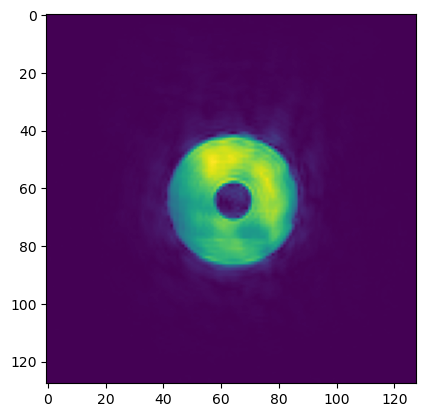

In [17]:
#Checking diffraction images
diff_1 = diff[0,3]

plt.imshow(diff_1.cpu())

In [65]:
n_filters_scale = 2
autoenc = Autoencoder(n_filters_scale)
autoenc.to('cuda')
autoenc_amp, autoenc_phase = autoenc(diff)

In [29]:
autoenc_phase.shape

torch.Size([64, 4, 128, 128])

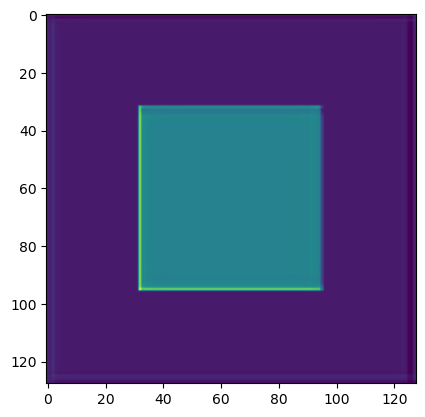

In [69]:
plt.imshow(autoenc_phase[3,0].detach().cpu())

In [70]:
combinecomplex = CombineComplex()
autoenc_combined = combinecomplex(autoenc_amp, autoenc_phase)

autoenc_combined.shape

torch.Size([64, 4, 128, 128])

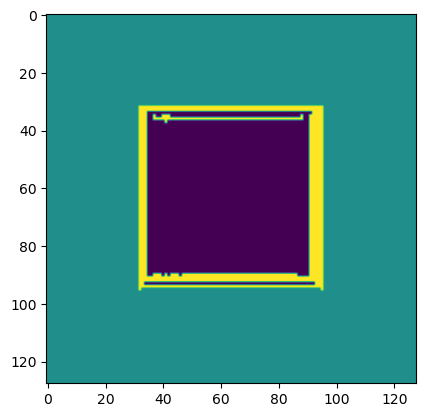

In [74]:
plt.imshow(autoenc_combined[0,3].detach().cpu().angle())

Reassemble patches

In [76]:
import ptycho_torch.helper as hh
from ptycho_torch.model import LambdaLayer

In [77]:
reassemble = LambdaLayer(hh.reassemble_patches_position_real)

In [80]:
positions[0].squeeze()

tensor([[ -6.8255,   8.7043],
        [  4.0697,   1.2832],
        [  9.5552,   3.2947],
        [ -6.7993, -13.2822]], device='cuda:0')

In [81]:
reassembled_out = reassemble(autoenc_combined, positions)

In [83]:
reassembled_out.shape

torch.Size([64, 142, 142])

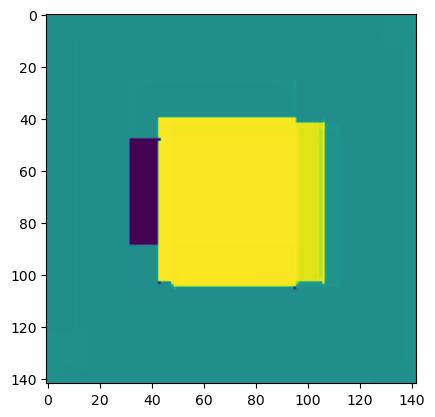

In [87]:
plt.imshow(reassembled_out[0].detach().cpu().angle())

In [88]:
test_complex_tensor = torch.complex(torch.randn(10, 10), torch.randn(10, 10))

test_complex_tensor[0,0]

tensor(0.8774+1.2504j)

In [89]:
test_complex_tensor[0,0], test_complex_tensor[0,0]/3

(tensor(0.8774+1.2504j), tensor(0.2925+0.4168j))